Deploying YOLOV3

In [ ]:
import io
import uvicorn
import numpy as np
import nest_asyncio
from enum import Enum
from fastapi import FastAPI, UploadFile, File, HTTPException
from fastapi.responses import StreamingResponse
from IPython.display import Image, display


Displaying image: clock2.jpg


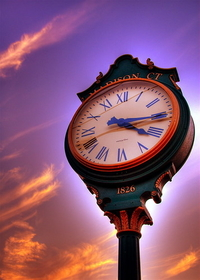


Displaying image: oranges.jpg


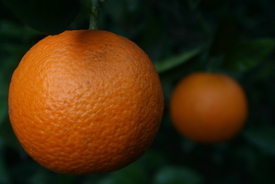


Displaying image: car3.jpg


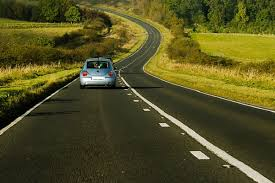

In [2]:
# Some example images
image_files = [
    'clock2.jpg',
    'oranges.jpg',
    'car3.jpg'
]

for image_file in image_files:
    print(f"\nDisplaying image: {image_file}")
    display(Image(filename=f"images/{image_file}"))

### Creating the detect_and_draw_box function

`yolov3-tiny`_: as the model name indicates, this model is designed for constrained environments that cannot store big models. With this comes a natural tradeoff: the results are less accurate than the full model. However, it still works pretty well. Going forward you can use whichever you prefer but by default `yolov3-tiny` will be used.

The model output is a vector of probabilities for the presence of different objects on the image. The last input argument, confidence level, determines the threshold that the probability needs to surpass to report that a given object is detected on the supplied image. By default, `detect_common_objects` uses a value of 0.5 for this.

In [9]:
import cv2
import cvlib as cv
from cvlib.object_detection import draw_bbox


def detect_and_draw_box(filename, model="yolov3-tiny", confidence=0.5):
    """Detects common objects on an image and creates a new image with bounding boxes.

    Args:
        filename (str): Filename of the image.
        model (str): Either "yolov3" or "yolov3-tiny". Defaults to "yolov3-tiny".
        confidence (float, optional): Desired confidence level. Defaults to 0.5.
    """
    
    # Images are stored under the images/ directory
    img_filepath = f'images/{filename}'
    
    # Read the image into a numpy array
    img = cv2.imread(img_filepath)
    
    # Perform the object detection
    bbox, label, conf = cv.detect_common_objects(img, confidence=confidence, model=model)
    
    # Print current image's filename
    print(f"========================\nImage processed: {filename}\n")
    
    # Print detected objects with confidence level
    for l, c in zip(label, conf):
        print(f"Detected object: {l} with confidence level of {c}\n")
    
    # Create a new image that includes the bounding boxes
    output_image = draw_bbox(img, bbox, label, conf)
    
    # Save the image in the directory images_with_boxes
    cv2.imwrite(f'images_with_boxes/{filename}', output_image)
    
    # Display the image with bounding boxes
    display(Image(f'images_with_boxes/{filename}'))

Let's try it out for the example images.

Image processed: fruits.jpg

Detected object: apple with confidence level of 0.5818483829498291

Detected object: orange with confidence level of 0.5346481204032898

Detected object: orange with confidence level of 0.515099287033081

Detected object: apple with confidence level of 0.3475988507270813

Detected object: orange with confidence level of 0.3287608325481415

Detected object: apple with confidence level of 0.31244662404060364

Detected object: orange with confidence level of 0.2798607349395752

Detected object: orange with confidence level of 0.2749975323677063

Detected object: apple with confidence level of 0.2744506299495697

Detected object: orange with confidence level of 0.2141905575990677



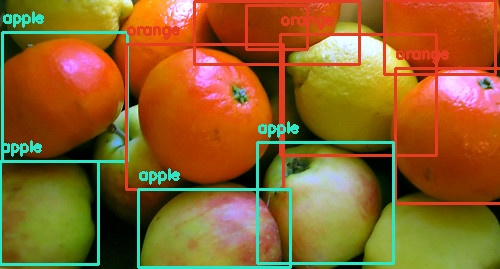

In [6]:
detect_and_draw_box("fruits.jpg", confidence=0.2)

## Deploying the model using fastAPI


In [8]:
# Assign an instance of the FastAPI class to the variable "app".
# You will interact with your api using this instance.
app = FastAPI(title='Deploying a ML Model with FastAPI')

# List available models using Enum for convenience. This is useful when the options are pre-defined.
class Model(str, Enum):
    yolov3tiny = "yolov3-tiny"
    yolov3 = "yolov3"


# By using @app.get("/") you are allowing the GET method to work for the / endpoint.
@app.get("/")
def home():
    return "Congratulations! Your API is working as expected."


# This endpoint handles all the logic necessary for the object detection to work.
# It requires the desired model and the image in which to perform object detection.
@app.post("/predict") 
def prediction(model: Model, file: UploadFile = File(...)):

    # 1. VALIDATE INPUT FILE
    filename = file.filename
    fileExtension = filename.split(".")[-1] in ("jpg", "jpeg", "png")
    if not fileExtension:
        raise HTTPException(status_code=415, detail="Unsupported file provided.")
    
    # 2. TRANSFORM RAW IMAGE INTO CV2 image
    
    # Read image as a stream of bytes
    image_stream = io.BytesIO(file.file.read())
    
    # Start the stream from the beginning (position zero)
    image_stream.seek(0)
    
    # Write the stream of bytes into a numpy array
    file_bytes = np.asarray(bytearray(image_stream.read()), dtype=np.uint8)
    
    # Decode the numpy array as an image
    image = cv2.imdecode(file_bytes, cv2.IMREAD_COLOR)
    
    
    # 3. RUN OBJECT DETECTION MODEL
    
    # Run object detection
    bbox, label, conf = cv.detect_common_objects(image, model=model)
    
    # Create image that includes bounding boxes and labels
    output_image = draw_bbox(image, bbox, label, conf)
    
    # Save it in a folder within the server
    cv2.imwrite(f'images_uploaded/{filename}', output_image)
    
    
    # 4. STREAM THE RESPONSE BACK TO THE CLIENT
    
    # Open the saved image for reading in binary mode
    file_image = open(f'images_uploaded/{filename}', mode="rb")
    
    # Return the image as a stream specifying media type
    return StreamingResponse(file_image, media_type="image/jpeg")

In [ ]:
# Allows the server to be run in this interactive environment
nest_asyncio.apply()

# This is an alias for localhost which means this particular machine
host = "127.0.0.1"

# Spin up the server!    
uvicorn.run(app, host=host, port=8000, root_path="/serve")

INFO:     Started server process [64]
INFO:     Waiting for application startup.
INFO:     Application startup complete.
INFO:     Uvicorn running on http://127.0.0.1:8000 (Press CTRL+C to quit)


The server is now running! Nice job!

## Consume your service

Normally you will now head over to `http://127.0.0.1:8000/` to see it in action. 

<a name='instructions'></a>
## Instructions to use the client



Click on top of the `/predict` endpoint and more options will become visible:

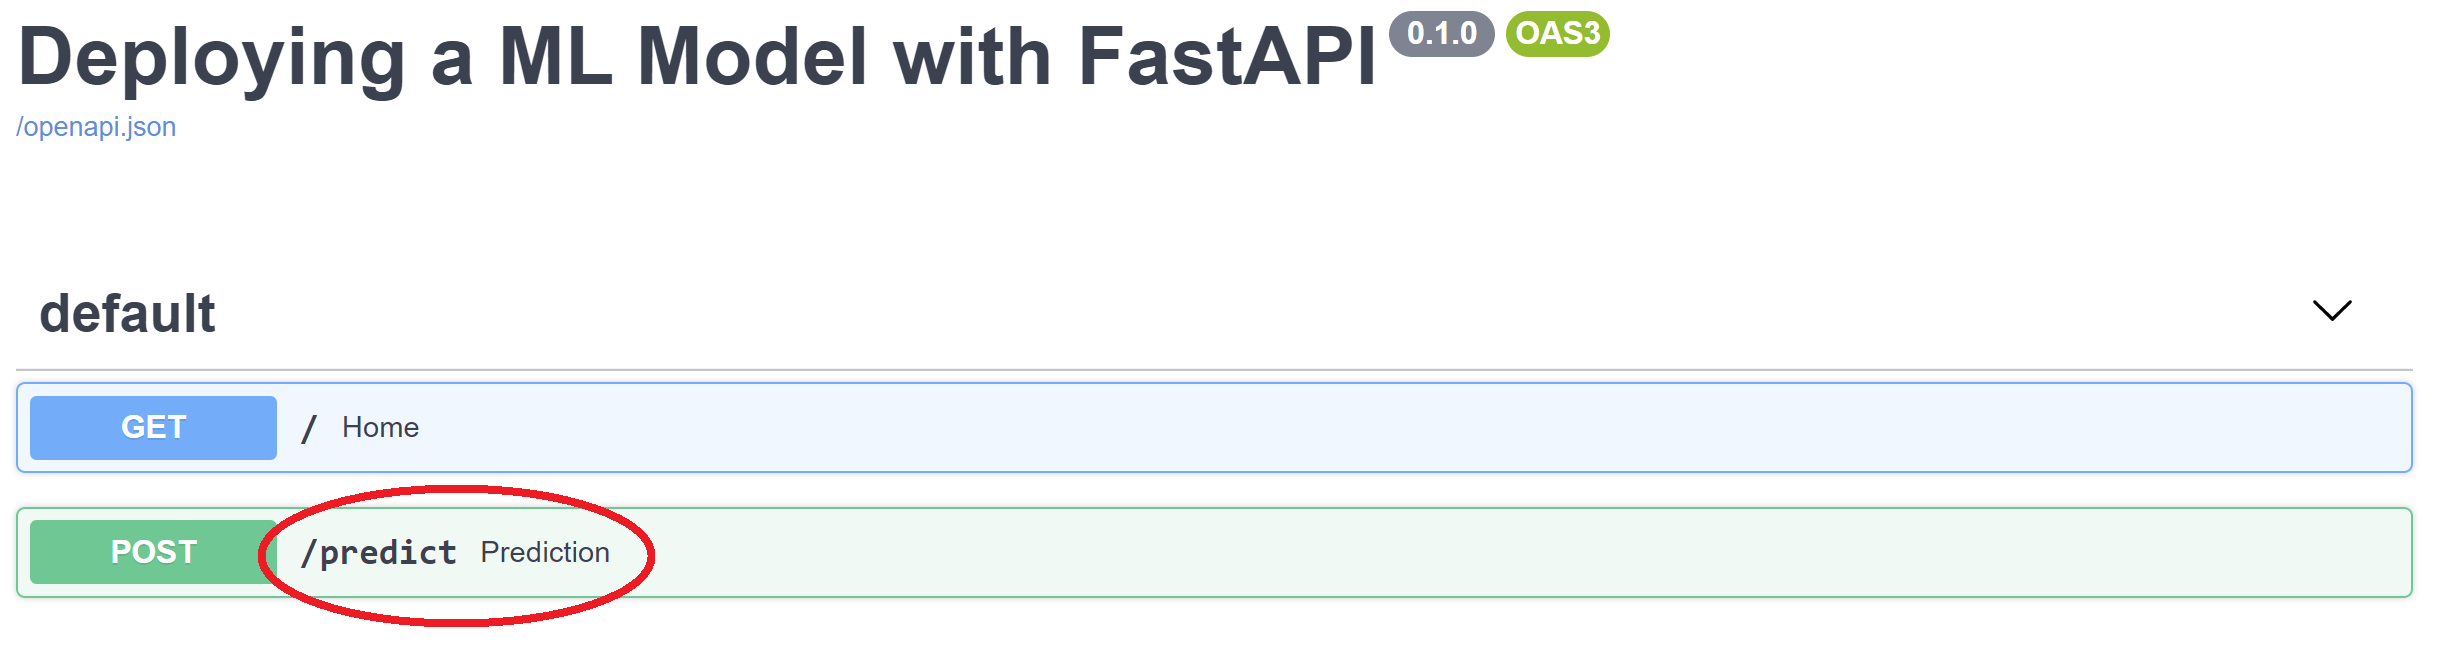



To test your server click on the **Try it out** button.

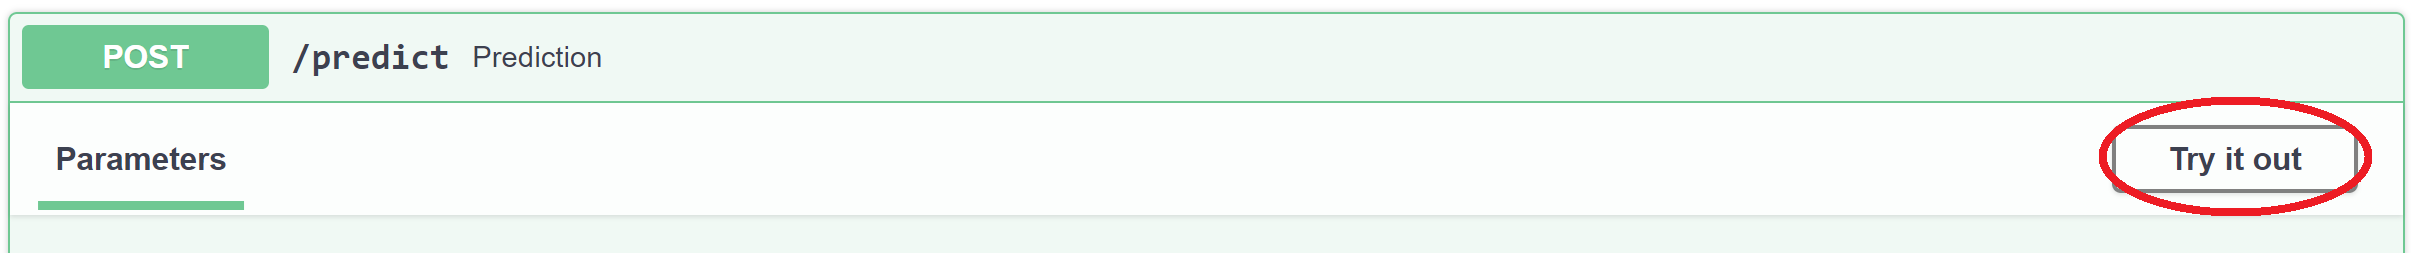

You can choose a model from the **model** field and a **file** which should be the image in which you want the server to detect objects.

**Submit an image** from your loca<l filesystem by clicking the **Choose File** button, then click on the blue **Execute** button to send an HTTP request to the server. After doing so, **scroll down and you will see the response from it**. Pretty cool, right?

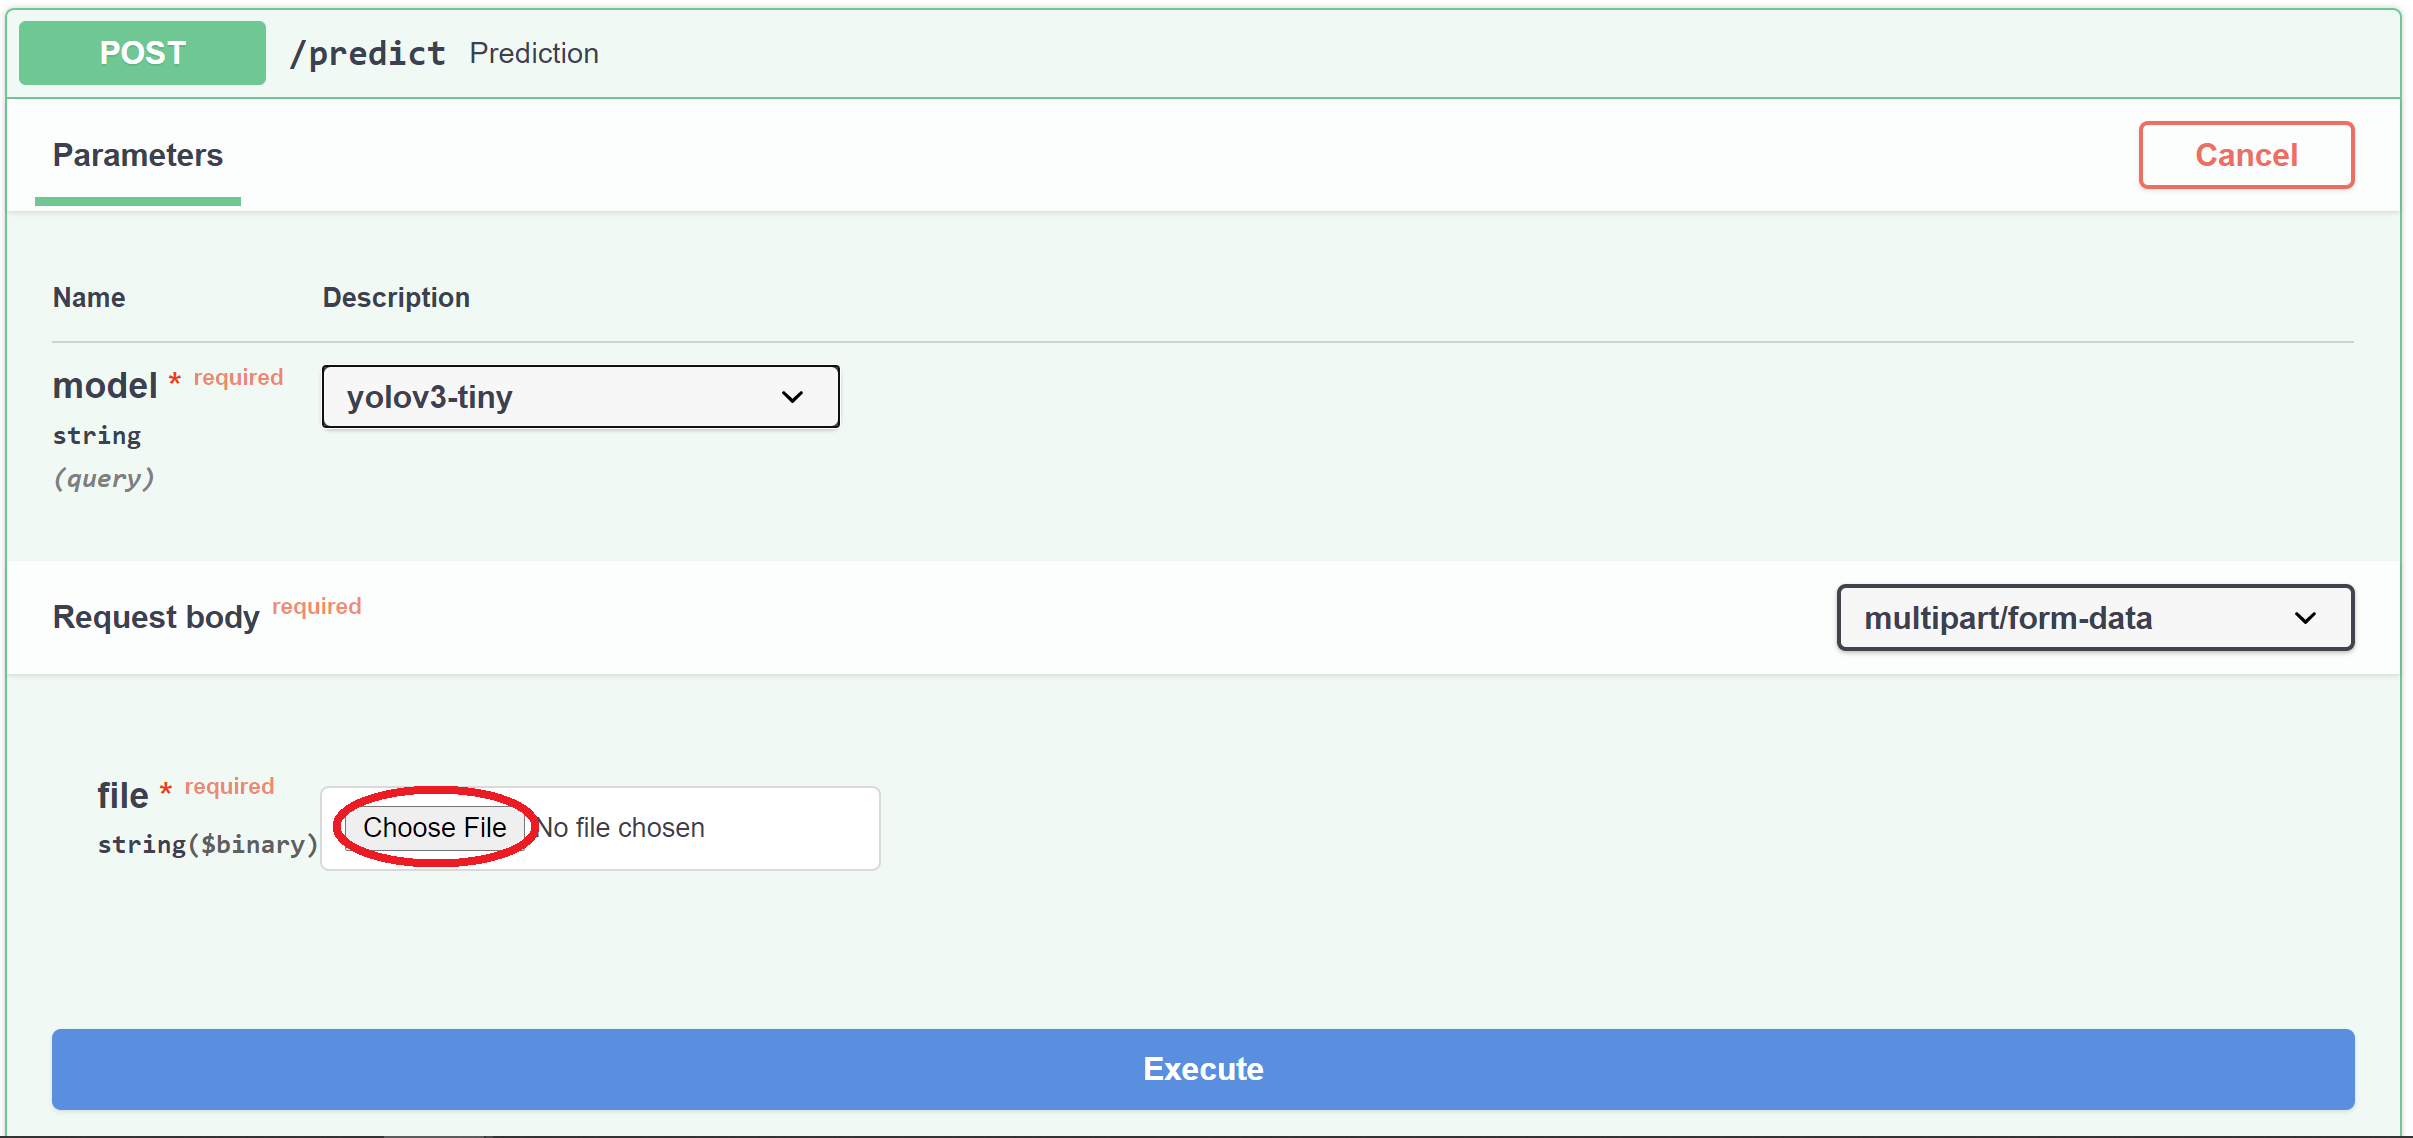